# 💡 MosaicX: **"Implicit Function Evaluation & Partitioning"**

> All code and examples are shared to help researchers, students, and engineers understand the reasoning behind DDDA — and to make it easy to apply dimensional analysis to your own data.  
> This notebook serves as an entry-level guide for teaching, validating physical models, and enabling domain-specific knowledge engineering through data-driven dimensional reasoning.

---

## 🎯 What You'll Learn

**隐函数最优显式化 - 机器科学家应用**

In this notebook, we will walk through the theoretical and computational foundation of **dimensional analysis**, with a focus on the **Buckingham Pi theorem**. You will learn:

1. **物理模型，隐函数，流形**  
   Understand why we reduce variables and how dimensional consistency enables model generalization.

2. **变量组合**  
   Encode physical units of input quantities using base units and build the D-matrix.

3. **变量组合评估**  
   Discover dimensionless groups by solving linear algebraic equations on the D-matrix.

4. **显式化策略可视化**  
   Learn to assess whether derived groups make physical and computational sense.

5. **不确定性定量化**  
   Set the stage for further steps in the DDDA pipeline including Pi-group selection, uncertainty quantification, and regime detection.

---

## 👤 Author

- **Name**: Jiashun Pang  
- **Created**: August 2025  
- **Affiliation**: DDDA Project, open research notebook  
- **Notebook Focus**:  
  A hands-on exploration of dimensional analysis — from aggregated raw quantities to symbolic Pi-group discovery and preparation for downstream DDDA tasks.

---

📌 *This notebook is designed to be accessible for learners new to dimensional analysis, while also laying the foundation for advanced applications in the full MosaicPi pipeline.*


---

# 1 · Implicit Function Theorem — General Multivariable Form & Geometric Interpretation

在物理建模中，由理论推导得到的方程往往体现为多个变量之间的复杂约束关系。
这些约束关系可以自然地被理解为一个 **高维曲面（在满足适当正则条件时是一个流形）**，其上所有的物理量组合都必须满足某种内在的平衡与守恒条件。

一个 **封闭的物理模型** 正是这种约束的数学表达形式。我们通常将其写作隐函数的形式：

$$
F(x_1, x_2, \dots, x_n) = 0,
$$

这里的 $F$ 可以包含守恒律、本构关系、边界条件等。

---

## 从隐函数到显函数

然而，如果我们想要对这些关系进行**求解、预测或外推**，隐函数形式本身并不足够。
隐函数仅仅描述了解集的存在性，却没有明确给出某个变量如何依赖于其余变量。
在满足**隐函数定理**条件时，可以在局部坐标系下，将隐函数关系转化为显函数：

$$
y = f(x_1, x_2, \dots, x_k),
$$

这对应于在流形上选取一组局部自变量坐标，其余变量作为因变量，从而得到流形在局部的“函数图像”。几何上，这一过程可直观地理解为一次在局部坐标方向上的投影。

---

## 显函数如同补丁

由于隐函数关系在全局往往无法唯一显式化（可能出现多解、分叉或奇异点），我们只能在局部邻域内将其转化为显函数。每一个局部显函数可以被视为覆盖在隐函数流形上的一个“补丁（patch）”。
通过在不同区域拼接这些补丁，我们能够得到对整体模型的分块化近似与表征。这一思想正是本工作的核心：

> **利用局部显函数的分区化描述，将隐函数模型拼接为由补丁组成的马赛克式结构，从而实现对物理规律的整体刻画。**

---

## 评估维度

为了实现这一目标，我们将在 notebook 中从以下几个角度对显函数的结构进行评估和判定：

* **可解性判定**：判断在给定区域内是否存在唯一的显函数解（Jacobian 的可逆性）。
* **稳定性判定**：分析解对输入扰动的稳定性（条件数与局部敏感度）。
* **敏感性判定**：评估各输入变量对结果的影响程度（Jacobian 的导数结构与误差传播）。

---

## 输入数据

在本 notebook 中，我们的输入分为两类：

1. **物理模型 (1.1)** — 由守恒律或理论推导得到的隐函数形式。
2. **实验/模拟数据 (1.2)** — 用于约束、验证和修正模型，帮助选择合适的显函数补丁。

---

👉 通过这一流程，我们将实现从 **物理模型（隐函数）** 出发，结合 **数据驱动的判定与验证**，最终得到一套分区化、补丁化的 **显函数拼贴结构**，为后续的外推与实验指导奠定基础。

---


## 1.1 物理模型

在 MosaicPi 中，物理模型作为一种 **先验约束** 被引入。最终的分析结果将在此先验的基础上进行拓展与迭代。

一个合格的物理模型需要满足以下基本要求：

* **封闭性**：模型应在所研究的变量集合上封闭，即通过引入本构关系或附加条件后，使未知量与独立方程数量匹配，从而能够自洽求解；
* **量纲齐次性**：所有方程在量纲上保持一致，为后续无量纲化与变量归一化提供基础；
* **理论合理性**：模型来源于明确的物理推理或守恒原理，并需注明适用条件（如流动状态、材料特性）。

模型的获取方式可以是用户直接输入，也可以从已有的学科数据库中调用。

在进入 MosaicPi 的分析流程时，我们首先会对输入的物理模型进行 **无量纲化处理**，从而将其标准化为隐函数形式，便于后续的 **Jacobian 判定** 与 **分区显函数化处理**。

---

## 1.2 实验 / 模拟数据

在 MosaicPi 中，实验或数值模拟数据作为物理模型的补充，用于：

* 约束与验证显函数的局部形式；
* 在分区边界或奇异点附近提供额外的信息；
* 量化模型的不确定性，并为迭代更新提供依据。

数据需要满足的基本要求：

* **可匹配性**：数据中的物理量应与模型变量一致，或能通过单位换算、变量映射或特征提取得到；
* **量纲一致性**：原始数据需附带清晰的物理单位，以便统一进行无量纲化处理；
* **充分性**：覆盖模型的主要变化范围，尤其是在敏感区域（Jacobian 接近退化处）；
* **置信度**：实验或模拟数据应提供误差估计，以便进行不确定性传播和加权拟合。

在进入流程时，所有数据会首先与物理模型保持一致地进行 **无量纲化**，然后与 Jacobian 分析结果结合，用于局部显函数拟合与分区判定。

---


## 1.3 示例

我们使用自制的**无空气阻力的抛体运动模型**在给定两条约束方程时的数据来进行**基点选择**与**可逆性判定**的完整演示。

* 选自变量块：$x=(R,H)$（水平射程、最高点高度）
* 选因变量块：$y=(v_0,\theta)$（初速度、发射角）
* 约束（$k=2$ 条）：

### 1.3.1 物理模型
**运动学公式：**
  $$
  R = \frac{v_0^2\sin(2\theta)}{g}, \quad H = \frac{v_0^2\sin^2\theta}{2g}
  $$

将它们改写成**零等式形式：**
  $$
  \begin{aligned}
  F_1(x,y)&=R-\frac{v_0^2\sin(2\theta)}{g}=0,\\
  F_2(x,y)&=H-\frac{v_0^2\sin^2\theta}{2g}=0.
  \end{aligned}
  $$

  于是 $F:\mathbb{R}^2\times\mathbb{R}^2\to\mathbb{R}^2$。

---

接下来我们使用代码示例，使用sympy对模型进行符号化的输入。

其中

- R - 水平射程（R）
- H - 最高点高度（H）
- v0 - 初速度（$v_0$）
- th - 发射角（$\theta$）
- g - 重力

In [2]:
import sympy as sp
import numpy as np

R, H, v0, th, g = sp.symbols('R H v0 th g', real=True)
F1 = R - (v0**2)*sp.sin(2*th)/g
F2 = H - (v0**2)*(sp.sin(th)**2)/(2*g)
F = sp.Matrix([F1, F2])

print('F_1: ', F[0], '\nF_2: ', F[1])

F_1:  R - v0**2*sin(2*th)/g 
F_2:  H - v0**2*sin(th)**2/(2*g)


### 1.3.2 实验 / 模拟数据
我们通过将随机自变量作为初始条件，对约束方程进行离散化处理，最终我们会得到两组因变量数据数组 **$R$：射程（水平位移的最大值）** 和 **$H$：最高点高度** 。


之后我们将包含已知的重力在内的五列数组保存为"ift_projectile_samples.csv"。

---

Saved to ift_projectile_samples.csv


,v0_mps,theta_deg,R_m,H_m,g_mps2
0,47.567583,67.319708,164.117239,98.178568,9.81
1,29.138314,15.764177,45.258010,3.194042,9.81
2,52.222886,47.885443,276.596126,76.489673,9.81
3,43.355242,46.137830,191.457143,49.804125,9.81
4,10.179754,73.605772,5.720516,4.860969,9.81


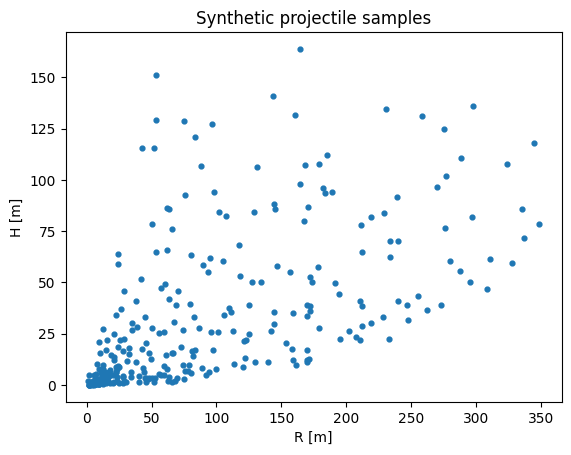

In [3]:
# --- Step 0: imports & knobs ---
import pandas as pd
import matplotlib.pyplot as plt

# 可调参数
N = 300                         # 样本数
g = 9.81                        # 重力加速度 [m/s^2]
v0_min, v0_max = 5.0, 60.0      # 初速度范围 [m/s]
th_min_deg, th_max_deg = 5.0, 85.0  # 角度范围 [deg]
seed = 42                       # 随机种子（复现实验）

# --- Step 1: generate samples ---
rng = np.random.default_rng(seed)
v0 = rng.uniform(v0_min, v0_max, size=N)
th = rng.uniform(th_min_deg, th_max_deg, size=N)
theta = np.deg2rad(th)

# 抛体运动（无阻力）的解析关系
R = (v0**2) * np.sin(2 * theta) / g
H = (v0**2) * (np.sin(theta)**2) / (2 * g)

# 如果想模拟测量噪声，可取消注释：
# R += rng.normal(0, 0.5, size=N)   # 射程噪声 [m]
# H += rng.normal(0, 0.2, size=N)   # 高度噪声 [m]

# --- Step 2: pack to DataFrame ---
df = pd.DataFrame({
    "v0_mps": v0,
    "theta_deg": th,
    "R_m": R,
    "H_m": H,
    "g_mps2": g
})

# --- Step 3: save & quick look ---
csv_path = "ift_projectile_samples.csv"
df.to_csv(csv_path, index=False)
print(f"Saved to {csv_path}")
display(df.head())

# --- Step 4: quick scatter plot (R vs H) ---
plt.figure()
plt.scatter(df["R_m"], df["H_m"], s=12)
plt.xlabel("R [m]")
plt.ylabel("H [m]")
plt.title("Synthetic projectile samples")
plt.show()


# 2. 曲面区域特征

当我们获得物理模型后，我们首先将其转化为隐函数的表示形式。例如，抛体运动的模型可以写为：

$$
\begin{aligned}
F_1(x,y) &= R - \frac{v_0^2 \sin(2\theta)}{g} = 0, \\
F_2(x,y) &= H - \frac{v_0^2 \sin^2\theta}{2g} = 0.
\end{aligned}
$$

---

## 2.1 Jacobian matrix

在隐函数场景下，**雅可比矩阵（Jacobian matrix）** 用于刻画函数在某一点的局部线性化特性。  
它是将“多个方程对多个变量的偏导数”排布成一个矩阵，用来分析局部的可解性、稳定性与敏感性。

假设有一个向量函数：
$$
\mathbf{F}(\mathbf{x}) =
\begin{bmatrix}
F_1(x_1,\dots,x_n) \\
F_2(x_1,\dots,x_n) \\
\vdots \\
F_m(x_1,\dots,x_n)
\end{bmatrix},
$$

其雅可比矩阵定义为：
$$
J(\mathbf{x}) =
\frac{\partial \mathbf{F}}{\partial \mathbf{x}} =
\begin{bmatrix}
\frac{\partial F_1}{\partial x_1} & \frac{\partial F_1}{\partial x_2} & \cdots & \frac{\partial F_1}{\partial x_n} \\
\frac{\partial F_2}{\partial x_1} & \frac{\partial F_2}{\partial x_2} & \cdots & \frac{\partial F_2}{\partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial F_m}{\partial x_1} & \frac{\partial F_m}{\partial x_2} & \cdots & \frac{\partial F_m}{\partial x_n}
\end{bmatrix}.
$$

- 标量函数时，Jacobian 退化为梯度向量。  
- 向量函数时，Jacobian 描述输入邻域被函数映射到输出空间的 **方向拉伸与压缩**。
- Jacobian 对应的是函数的一阶线性近似。如果要捕捉非线性曲率效应，则需要进一步引入 Hessian 矩阵（二阶偏导数），它提供函数在局部的弯曲信息。

> *Remark:* 在 ODE 系统中，Jacobian 通常表示为 $\partial f/\partial x$，用于稳定性和分岔分析；在 PDE 系统中，经过数值离散后也会得到 Jacobian，用于牛顿迭代和灵敏度计算。
> 关于二阶 Hessian 的应用（如临界点分类、非线性误差传播等），将在后续高级案例中再介绍。

---

## 2.2 空间扫描

在获得 Jacobian 之后，我们需要进行类似“空间扫描”的操作，以评估不同变量组合下的显函数可行性。其基本框架为：

* **横向（列）**：不同的因变量分组（y-block）。

  * 若有 $m$ 个约束方程，每次必须选择恰好 $m$ 个变量作为因变量，构成 Jacobian submatrix：

    $$
    J_y = \frac{\partial F}{\partial y}.
    $$
  * 其余变量作为自变量。
  * → 这对应于 **因变量证否**：对于不同的因变量分组，判断它们是否能在某一区域内成功显函数化。

* **纵向（行）**：不同的样本点（基点）。

  * 可以来自实验/模拟数据，也可以是模型定义域内的采样点。
  * 每个采样点代表 Jacobian 在不同局部的数值特征。
  * → 这对应于 **基点证否**：即使在同一分组下，不同基点的可解性也可能不同，有的点可解，有的点处于边界或奇异点附近。

这样就形成了一个二维“扫描矩阵”：

* 行：样本点（基点证否）
* 列：候选因变量分组（因变量证否）
* 每个单元格存储该组合在该点的可解性 / 稳定性 / 敏感性指标。

---

以抛体运动模型的例子来看，我们先总结出它的隐函数表示：

$$
F(R, H, \theta, g, v_0) = 0,
$$

在下方的表格中：

* 列代表不同的因变量分组（即因变量证否的横向扫描）。
* 行代表我们通过实验得到的采样点位置，也就是基点（基点证否的纵向扫描）。

每一列对应一个因变量组合（即$y$-block），在不同采样点上检查其 Jacobian 子矩阵的可逆性。

$$
J_{i, y} := \left.\frac{\partial F}{\partial y}\right|_{x = x^{(i)}}
$$


> 在下方的表格中，每一列对应一个因变量分组（即 \$y\$-block），每一行对应一个采样点。在单元格中，我们计算该分组对应的 Jacobian 子矩阵 \$J\_{i,y} = \left.\frac{\partial F}{\partial y}\right|\_{x = x^{(i)}}\$，并判定其在该点是否可逆。
> 
> 在实际数值计算中，常用 $\sigma_{\min}$ 或条件数来判定局部可逆性，而不是单纯依赖 $\det J_y$。

<br>

<table border="1" cellspacing="0" cellpadding="6">
  <caption>不同的因变量分组（y-block）</caption>
  <tr>
    <th rowspan="7" style="writing-mode: vertical-rl; text-align: center;">
      采样点（基点证否）
    </th>
    <td></td>
    <td>(R, g)</td>
    <td>(R, H)</td>
    <td>(H，$\theta$)</td>
    <td>(R, $\theta$)</td>
    <td>(R, $v_0$)</td>
    <td>(H, g)</td>
    <td>(...)</td>
  </tr>
  <tr>
    <th>1</th>
    <td>$J_{1, (R, g)}$</td>
    <td>$J_{1, (R, H)}$</td>
    <td>$J_{1, (H，\theta)}$</td>
    <td>$J_{1, (R, \theta)}$</td>
    <td>$J_{1, (R, v_0)}$</td>
    <td>$J_{1, (H, g)}$</td>
  </tr>
  <tr>
    <th>2</th>
    <td>$J_{2, (R, g)}$</td>
    <td>$J_{2, (R, H)}$</td>
    <td>$J_{2, (H，\theta)}$</td>
    <td>$J_{2, (R, \theta)}$</td>
    <td>$J_{2, (R, v_0)}$</td>
    <td>$J_{2, (H, g)}$</td>
  </tr>
  <tr>
    <th>3</th>
    <td>$J_{3, (R, g)}$</td>
    <td>$J_{3, (R, H)}$</td>
    <td>$J_{3, (H，\theta)}$</td>
    <td>$J_{3, (R, \theta)}$</td>
    <td>$J_{3, (R, v_0)}$</td>
    <td>$J_{3, (H, g)}$</td>
  </tr>
  <tr>
    <th>4</th>
    <td>$J_{4, (R, g)}$</td>
    <td>$J_{4, (R, H)}$</td>
    <td>$J_{4, (H，\theta)}$</td>
    <td>$J_{4, (R, \theta)}$</td>
    <td>$J_{4, (R, v_0)}$</td>
    <td>$J_{4, (H, g)}$</td>
  </tr>
  <tr>
    <th>5</th>
    <td>$J_{5, (R, g)}$</td>
    <td>$J_{5, (R, H)}$</td>
    <td>$J_{5, (H，\theta)}$</td>
    <td>$J_{5, (R, \theta)}$</td>
    <td>$J_{5, (R, v_0)}$</td>
    <td>$J_{5, (H, g)}$</td>
  </tr>
  <tr>
    <th>...</th>
  </tr>
</table>

---

### 证否逻辑说明

* **因变量证否（横向）**：判断某一因变量组合是否具备局部可解性；如果在大量基点上 $\det J_y \approx 0$，说明该分组在整体上并不适合作为显函数化的选择。
* **基点证否（纵向）**：即使某一分组整体可行，在某些特定点上也可能退化到边界、奇异点或分叉点，从而导致局部显函数失效。

因此，空间扫描实际上是 **因变量选择 × 基点选择的二维交互检验**：

* 横向 → 哪些分组有潜力。
* 纵向 → 在什么范围内这些分组是可行的。
* 交叉 → 构建出显函数可解性的“马赛克地图”，为后续补丁拼贴奠定基础。

---

## 2.3 局部函数的可逆性判定

这里的“可逆性判定”实际上是指“$y$ 是否能局部作为 $x$ 的函数存在且唯一”，在隐函数定理的框架下，**可逆性判定**就是回答这样一个问题：

> 在给定的方程组约束下，某个变量分组 $y$ 是否能够在选定基点 $(x_0,y_0)$ 的邻域中，被唯一地表示为 $x$ 的函数？

换句话说，可逆性实际上就是显函数存在性与唯一性的局部判定条件。

---

### 2.3.1 理论条件

设方程组为

$$
F(x,y) = 0, \quad F:\mathbb{R}^{n+m} \to \mathbb{R}^m,
$$

其中 $x \in \mathbb{R}^n$ 表示自变量组，$y \in \mathbb{R}^m$ 表示因变量组。

* 构造关于因变量 $y$ 的 Jacobian 子矩阵（$m\times m$ 矩阵（因为 $F\in\mathbb{R}^m$，$y\in\mathbb{R}^m$））：

  $$
  J_y(x,y) = \frac{\partial F}{\partial y}(x,y).
  $$，  

* 在某个基点 $(x_0,y_0)$ 处，如果满足

  $$
  \det J_y(x_0,y_0) \neq 0,
  $$

  那么根据隐函数定理，就存在一个邻域 $U$，使得在该邻域内，因变量 $y$ 可以唯一地表示为 $x$ 的函数：

  $$
  y = f(x), \quad (x,y)\in U.
  $$

---

### 2.3.2 直观解释

1. **几何角度**：

   * 隐函数曲面 $F(x,y)=0$ 是高维空间中的一个流形。
   * 判定 $\det J_y \neq 0$ 等价于说：在这一点附近，曲面相对于 $y$-方向的投影不塌缩。
   * 因此我们能把曲面“展开”为 $y=f(x)$ 的形式。

2. **代数角度**：

   * $\det J_y \neq 0$ 意味着方程组关于 $y$ 的线性化系统可解且唯一。
   * 如果 $\det J_y = 0$，则局部秩降低，解可能不唯一或不存在，显函数形式失效。

---

### 2.3.3 局部可解性的意义

* **显函数化的可能性**：只有当 $J_y$ 在基点处可逆时，才能保证在该邻域内显函数存在。
* **区域划分的必要性**：一旦 $\det J_y$ 在某些区域趋近于零，就意味着这一组因变量不再适合作为显函数表示，需要更换分组或重新划分补丁。这是因为某些 $y$ 分组不再适合作为因变量，此时可以尝试交换 $x$ 与 $y$ 的角色，或在不同区域采用不同的局部坐标。
* **物理直觉**：在实验数据中，这通常对应“转捩点”“奇异点”或“退化情形”。

---

### 2.3.4 例1：单位圆上的可逆性（**基点证否**）

$$
F(x,y) = x^2 + y^2 - 1 = 0,
$$


**（1）因变量 $y$** 的 Jacobian 子矩阵就是：

  $$
  J_y = \frac{\partial F}{\partial y} = 2y.
  $$

* 在点 $(x_0,y_0) = (0,1)$：

  $$
  J_y(0,1) = 2 \neq 0 \quad \Rightarrow \quad \text{可解}.
  $$

  → 在该点附近，可以写作 $y = f(x) = +\sqrt{1-x^2}$。

* 在点 $(x_0,y_0) = (0, 0)$：

  $$
  J_y(0,0) = 0 \quad \Rightarrow \quad \text{不可解}.
  $$

**（2）因变量 $x$** 的 Jacobian 子矩阵就是：

  $$
  J_x = \frac{\partial F}{\partial x} = 2x.
  $$

* 在点 $(x_0,y_0) = (1, 0)$：

  $$
  J_x(0,1) = 2 \neq 0 \quad \Rightarrow \quad \text{可解}.
  $$

  → 在该点附近，可以写作 $y = f(x) = +\sqrt{1-x^2}$。

* 在点 $(x_0,y_0) = (0,0)$：

  $$
  J_x(0,0) = 0 \quad \Rightarrow \quad \text{不可解}.
  $$


**（3）基点证否**
我们比较 **同一个基点 $(0,0)$**：

- 当选择 $y$ 作为因变量时，$J_y(0,0)=0$ → 不能解出 $y=f(x)$.

- 当选择 $x$ 作为因变量时，$J_x(0,0)=0$ → 也不能解出 $x=f(y)$.

这就说明：在 $(0,0)$ 这个点，**无论怎样分组，投影都会塌缩**，所以隐函数定理无法适用。

---

### 2.3.4 例2：椭圆上的可逆性（**分组证否**）

$$
F(x,y)=x^2+4y^2-1=0
$$


**(1) y为因变量**

$$
J_y = \frac{\partial F}{\partial y} = 8y
$$

* 在基点 \$(0,\tfrac{1}{2})\$：

  $$
  J_y(0,\tfrac{1}{2}) = 8 \cdot \tfrac{1}{2} = 4 \neq 0
  $$

  ✅ 可以解，\$y = f(x) = \pm \tfrac{1}{2}\sqrt{1-x^2}\$ 的上支。


**(2) x为因变量**

$$
J_x = \frac{\partial F}{\partial x} = 2x
$$

* 在基点 \$(0,\tfrac{1}{2})\$：

  $$
  J_x(0,\tfrac{1}{2}) = 0
  $$

  ❌ 不可解，无法写成 \$x=g(y)\$。


**分组证否**

* **在基点 \$(0,\tfrac{1}{2})\$**：

  * 选择 \$y\$ 为因变量 → 可解。
  * 选择 \$x\$ 为因变量 → 不可解。

这说明：**基点没有被证否，但分组选择导致了局部失效**。这正是“**分组证否**”的典型情形。


**直观理解**：

* 在点 \$(0,\tfrac{1}{2})\$，椭圆在 \$y\$ 方向“竖直可展开”，但在 \$x\$ 方向上切线是竖直的 → \$x\$ 投影塌缩。
* 所以能解 \$y=f(x)\$，却不能解 \$x=f(y)\$。

---


### 解释
#### 1. 因变量分组 ≠ 绝对选择，而是 **相对基点的选择**

* 从隐函数定理的角度看，选择哪个变量做“因变量”就是在决定你把曲面投影到哪个坐标方向上。
* 这个投影在某些基点处是可行的（Jacobian 不为 0），在另一些基点就可能塌缩。
* 因此，分组的合理性并不是全局固定的，而是 **基点相关的**。

---

#### 2. “因变量分组” 与 “局部补丁”

* 你之前的理解是：因变量分组是为了构造局部显函数（\$y=f(x)\$）。
* 现在可以更进一步：**每个基点决定了能不能用某个分组来展开一个补丁**。

  * 在基点 \$(0,1)\$，单位圆可以写成 \$y=f(x)\$；
  * 在基点 \$(1,0)\$，更合适的是 \$x=f(y)\$；
  * 在 \$(0,0)\$，两个分组都失败 → 需要其他参数化方式。
* 所以，因变量分组实际上就是**在不同基点上选择不同的投影方式**，从而拼接出流形的不同局部补丁。

---

#### 3. 物理直觉

在实验或数值建模里，这也很自然：

* 你在某个实验条件（基点）下观测系统，可能发现某个物理量（比如压强）能很好地表达为温度的函数，但不能反过来。
* 换一个实验条件（另一个基点），情况可能正好相反。
* 所以“分组选择”并不是一劳永逸的，而是和**你所处的基点**绑定的。

---

📌 **一句话总结**：
因变量分组并不是纯粹的“对局部函数形式的全局规定”，而是与基点相配合的“投影选择”；它决定了在该基点附近能否展开一个良好的局部显函数补丁。


In [4]:
# 圆的基点证否示例

import sympy as sp

# 定义符号变量
x, y = sp.symbols('x y')

# 定义隐函数方程：单位圆
F = x**2 + y**2 - 1

# 计算关于 y 的 Jacobian 子矩阵
J_y = sp.diff(F, y)

# 定义几个测试点
points = [(0, 1), (0, 0), (sp.Rational(1,2), sp.sqrt(3)/2)]

print("Jacobian submatrix wrt y:", J_y)

for pt in points:
    val = J_y.subs({x: pt[0], y: pt[1]})
    print(f"At point {pt}: J_y = {val}, ", end="")
    if val != 0:
        print("✅ 可解，可以展开为 y=f(x)")
    else:
        print("❌ 不可解，显函数形式失效")


Jacobian submatrix wrt y: 2*y
At point (0, 1): J_y = 2, ✅ 可解，可以展开为 y=f(x)
At point (0, 0): J_y = 0, ❌ 不可解，显函数形式失效
At point (1/2, sqrt(3)/2): J_y = sqrt(3), ✅ 可解，可以展开为 y=f(x)


✅ 这个例子展示了：

* 当 $J_y \neq 0$ 时，隐函数可以展开为显函数。
* 当 $J_y = 0$ 时，显函数描述失效，提示需要换基点或重新分组。

但其实我们可以看到，就圆形函数 $F$ 而言：

$$
F(x,y) = x^2 + y^2 - 1 = 0,
$$

$(0, 0)$ 点作为基点是不可能成立的，因为它本身不满足物理约束（不在解流形上），实验或模拟数据也不可能给出这一点。

---

### 启发

* **实验基点**：必须来自实际可观测或可模拟的数据，因此天然满足约束方程 $F(x,y)=0$。这意味着像 $(0,0)$ 这样的点永远不会进入实验分析。
* **理论基点**：在隐函数定理和 Jacobian 扫描中，我们仍然可以把这些“不可实现点”纳入考虑，用来揭示模型的极限性质和退化情况。

👉 对 MosaicPi 的意义是：

* **实验数据部分**，我们只会在物理可行点上进行可逆性判定；
* **模型扫描部分**，我们可以在更广的定义域上测试 Jacobian，从而识别潜在的奇异点、边界点或分叉点。

这样一来，实验数据和理论模型就形成互补：数据保证了“现实约束”，模型扩展了对“极端条件”的理解。

---

### 2.3.5 更稳健的可逆性判定

在隐函数理论中，局部可逆性的最基本判据是：

$$
\det(J_y) \neq 0,
$$

即 Jacobian 子矩阵在该点处非奇异。但在数值计算和实际数据处理中，这种**行列式判定非常脆弱**：

* 行列式会随变量缩放剧烈变化，数值上可能“虚假接近零”；
* 高维系统中，$\det(J_y)$ 的正负号可以用来判断方向，但绝对值缺乏可比性；
* 在浮点计算下，舍入误差可能导致错误的“零判定”。

因此，我们需要一种更加鲁棒（robust）的指标来判断可逆性和数值稳定性。

---

#### 🔹 奇异值分解（SVD）

对 Jacobian 子矩阵 $J_y$ 进行奇异值分解：

$$
J_y = U \Sigma V^T, \quad \Sigma = \operatorname{diag}(\sigma_1, \dots, \sigma_m), \quad \sigma_1 \geq \dots \geq \sigma_m \geq 0,
$$

* **最小奇异值** $\sigma_{\min}(J_y)$：衡量矩阵最“弱方向”的拉伸尺度。若 $\sigma_{\min} \to 0$，说明矩阵接近奇异点（ill-posed）。
* **最大奇异值** $\sigma_{\max}(J_y)$：衡量矩阵最“强方向”的拉伸尺度。

---
#### 🔹 条件数与稳定性

定义条件数：

$$
\kappa(J_y) = \frac{\sigma_{\max}(J_y)}{\sigma_{\min}(J_y)}.
$$

* 条件数越大，数值解对输入扰动越敏感。
* 在可逆性已经成立（$\sigma_{\min} > 0$）的前提下，条件数能进一步揭示解的**稳定性与误差放大效应**。

直观理解：

* $\det(J_y)$ 只告诉你“门能不能打开”；
* $\kappa(J_y)$ 告诉你“门打开之后是不是一推就晃，还是稳稳固固”。

---

#### 🔹 符号信息

虽然行列式的绝对值并不可靠，但它的符号仍然有意义：

* $\operatorname{sign}\det(J_y)$ 可以用来区分不同分支或判断局部方向性；
* 例如在分叉点附近，符号变化提示显函数描述需要切换。

---

#### 🔹 判定分级示例（可调节）

在实际操作中，我们可以设置分级阈值：

* **安全区域**：
  $\kappa(J_y) \leq 10^6$，数值稳定，可逆性可靠。
* **警戒区域**：
  $10^6 < \kappa(J_y) \leq 10^8$，可逆性仍成立，但解对扰动敏感，建议记录并谨慎使用。
* **失效区域**：
  $\kappa(J_y) > 10^8$ 或 $\sigma_{\min}/\sigma_{\max} < 10^{-8}$，显函数化失败，需要切换因变量组合或重新分区。

> ⚠️ 注：阈值（$10^6, 10^8$）并非绝对标准，而是工程和数值计算中常用的经验等级。具体应用时应根据数据精度与问题规模调整。

---

✅ 总结
相比于单纯的行列式判定，**奇异值与条件数**提供了更全面的可逆性刻画：

* $\sigma_{\min}$：是否接近奇异点；
* $\kappa$：数值解的稳定性；
* $\operatorname{sign}\det$：分支与方向信息。

三者结合，才能在 MosaicPi 框架下稳定、可靠地完成 **因变量选择 → 局部显函数化 → 分区拼贴** 的过程。

---


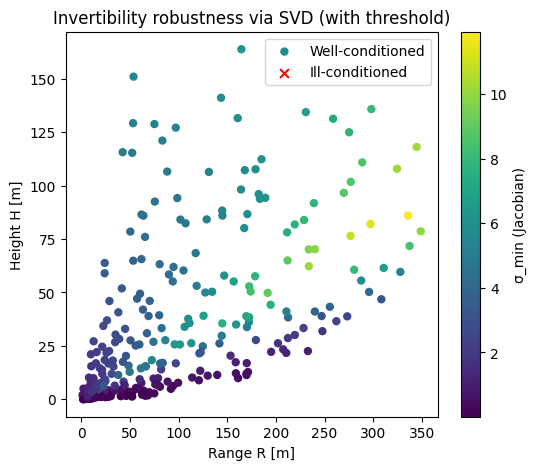

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 0: imports & knobs ---
N = 300
g = 9.81
v0_min, v0_max = 5.0, 60.0
th_min_deg, th_max_deg = 5.0, 85.0
seed = 42
tol = 1e-3   # 可逆性判定阈值

# --- Step 1: generate samples ---
rng = np.random.default_rng(seed)
v0 = rng.uniform(v0_min, v0_max, size=N)
th = rng.uniform(th_min_deg, th_max_deg, size=N)
theta = np.deg2rad(th)

# 抛体运动解析公式
R = (v0**2) * np.sin(2 * theta) / g
H = (v0**2) * (np.sin(theta)**2) / (2 * g)

df = pd.DataFrame({
    "v0_mps": v0,
    "theta_deg": th,
    "R_m": R,
    "H_m": H,
    "g_mps2": g
})

# --- Step 2: 计算Jacobian ---
dR_dv0 = (2*v0/g) * np.sin(2*theta)
dR_dtheta = (2*v0**2/g) * np.cos(2*theta)
dH_dv0 = (v0/g) * (np.sin(theta)**2)
dH_dtheta = (v0**2/g) * np.sin(theta) * np.cos(theta)

jacobians = np.array([
    [[dR_dv0[i], dR_dtheta[i]],
     [dH_dv0[i], dH_dtheta[i]]]
    for i in range(N)
])

# --- Step 3: SVD & 指标 ---
sigma_min, sigma_max, cond_number = [], [], []

for J in jacobians:
    _, S, _ = np.linalg.svd(J)
    sigma_min.append(S.min())
    sigma_max.append(S.max())
    # cond_number.append(S.max()/S.min() if S.min() > 1e-12 else np.inf)

df["sigma_min"] = sigma_min
df["sigma_max"] = sigma_max
df["invertible"] = df["sigma_min"] >= tol

# --- Step 4: 可视化 ---
plt.figure(figsize=(6,5))

# 可逆点：σ_min >= tol，用颜色表示 σ_min
sc = plt.scatter(df.loc[df["invertible"], "R_m"],
                 df.loc[df["invertible"], "H_m"],
                 c=df.loc[df["invertible"], "sigma_min"],
                 cmap="viridis", s=25, label="Well-conditioned")

# 不可逆点：σ_min < tol，用红色叉号表示
plt.scatter(df.loc[~df["invertible"], "R_m"],
            df.loc[~df["invertible"], "H_m"],
            c="red", marker="x", s=40, label="Ill-conditioned")

plt.colorbar(sc, label="σ_min (Jacobian)")
plt.xlabel("Range R [m]")
plt.ylabel("Height H [m]")
plt.title("Invertibility robustness via SVD (with threshold)")
plt.legend()
plt.show()

# # 条件数分布
# plt.figure()
# plt.hist([c for c in cond_number if c < 1e6], bins=40, color="steelblue")
# plt.axvline(1/tol, color="red", linestyle="--", label=f"Threshold ~ 1/{tol}")
# plt.xlabel("Condition number κ(J)")
# plt.ylabel("Count")
# plt.title("Distribution of Jacobian condition numbers")
# plt.legend()
# plt.show()

**Invertibility robustness via SVD (with threshold)** 中可以看到

* **基点 (0,0)** 可以视为 **奇异点**：初速度 $v_0=0$ 或角度退化时，Jacobian 退化，系统不可逆。
* **颜色条含义**：

  * $\sigma_{\min}$ 越大（→ 黄色），说明在该点局部映射最“薄弱方向”也有足够拉伸，不接近奇异 → **远离奇异点**。
  * $\sigma_{\min}$ 越小（→ 紫色），说明 Jacobian 在某个方向上几乎塌缩 → **接近奇异点**。
* **红叉（Ill-conditioned）**：就是你设的阈值 $\sigma_{\min}<10^{-3}$，直接标记为不可逆/病态区域。
* **条件数的直方图**（第二张图）：进一步补充了“虽然不是零，但 κ 很大”的数值不稳定区域。

---

📌 **总结**：

* det(J)：告诉你 (0,0) 是奇异点；
* $\sigma_{\min}$（配色）告诉你 **离奇异点远近**；
* $\kappa$（直方图）告诉你 **在远离奇异点时是否数值稳定**。

👉 你的理解完全正确：图中“偏黄 = σ\_min 大 = 离奇异点远”，“偏紫 = σ\_min 小 = 离奇异点近”。

---

要不要我帮你把这三类指标（det / σ\_min / κ）的可视化方式整理一下？比如：

* det → 等值线（标边界）
* σ\_min → 连续色彩映射（风险远近）
* κ → 热力图或直方图（数值敏感度）

这样你就能给 MosaicX 的 Notebook 做一个“可逆性判定三件套”的统一展示。


### 隐函数显式组合的存在性与稳定性筛选

## 1️⃣ 为什么先要选基点 $(x_0, y_0)$

* **隐函数定理是局部结果**：它不保证全局解，只保证在某个点附近存在唯一解 $y = g(x)$。
* 基点 $(x_0, y_0)$ 就是你检验这个局部可解性的“起始位置”，它必须满足：

  $$
  F(x_0, y_0) = 0
  $$

  也就是说，这个点在你的约束曲面（或流形）上。
---

## 2️⃣ 基点的作用

* **检验可解性条件**：
  在 $(x_0, y_0)$ 处计算 $J_yF(x_0, y_0)$，判断它是否可逆：

  $$
  \det J_yF(x_0, y_0) \neq 0
  $$

  如果成立，就能在该点附近把 $y$ 表示成 $x$ 的函数。
* **确定局部近似**：
  基点给了你线性化的中心，可以用

  $$
  \mathrm{d}y = - J_y^{-1} J_x\, \mathrm{d}x
  $$

  得到 $g'(x_0)$，作为切平面或一阶近似。
* **后续分区依据**：
  如果在不同区域选择不同的基点，可能会得到不同的 $x/y$ 分块方式，这就是**自动分区实验域**的基础。

---



**可解性条件（对 $y$ 可解）**：计算 $J_y=\partial F/\partial (v_0,\theta)$ 的行列式：

$$
\det J_y=\frac{2 v_0^3 \sin^2\theta}{g^2}.
$$

因此只要 $v_0\neq 0$ 且 $\sin\theta\neq 0$（即 $\theta\notin\{0,\pi\}$），就满足隐函数定理：在该基点附近可以局部写成 $y=g(x)$。


### 下边的代码是使用sympy进行符号计算的过程

**Step 0：** 先列出参数，噪声，输出内容等数据

In [9]:
# ===============================================
# Implicit-function existence & stability screening
# (Projectile motion, drag-free) — with comments
# ===============================================

# --- Step 0: imports & knobs ---
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt

from itertools import combinations
from numpy.linalg import inv, cond, norm, LinAlgError

# ===== 可调参数 =====
N = 300                          # 样本数
g_val = 9.81                     # 重力加速度 [m/s^2]
v0_min, v0_max = 5.0, 60.0       # 初速度范围 [m/s]
th_min_deg, th_max_deg = 5.0, 85.0  # 发射角范围 [deg]
seed = 42                        # 随机种子（复现实验）

add_noise = False                # 是否添加观测噪声
noise_R = 0.5                    # 射程噪声 [m]
noise_H = 0.2                    # 最高点噪声 [m]

save_csv = True                  # 是否保存CSV
make_plots = True                # 是否画图（直方图）

# 数值阈值（行列式与可解性）
EPS_DET = 1e-12




**Step 1：** 对采样点进行数据生成，写入物理方程

  $$
  R = \frac{v_0^2\sin(2\theta)}{g}, \quad H = \frac{v_0^2\sin^2\theta}{2g}
  $$

In [10]:
# --- Step 1: generate samples (synthetic, no-drag) ---
rng = np.random.default_rng(seed)

# 物理原始变量：v0, theta
v0 = rng.uniform(v0_min, v0_max, size=N)
theta_deg = rng.uniform(th_min_deg, th_max_deg, size=N)
theta = np.deg2rad(theta_deg)   # 统一用弧度做计算

# 无阻力抛体关系
R = (v0**2) * np.sin(2 * theta) / g_val
H = (v0**2) * (np.sin(theta)**2) / (2 * g_val)

# 可选：加入观测噪声（模拟实验测量）
if add_noise:
    R = R + rng.normal(0, noise_R, size=N)
    H = H + rng.normal(0, noise_H, size=N)

df = pd.DataFrame({
    "v0_mps": v0,
    "theta_deg": theta_deg,
    "R_m": R,
    "H_m": H,
    "g_mps2": g_val
})

if save_csv:
    df.to_csv("ift_projectile_samples.csv", index=False)

**Step 2：** 创建符号矩阵，计算Jacobian


> **雅可比矩阵的定义**

> 在隐函数场景下，**雅可比矩阵（Jacobian matrix）** 可以理解为把“多个方程对多个变量的偏导”排成一个矩阵，用来描述函数在某个点的 **局部线性化** 特性。

> 假设你有一个向量函数

> $$
\mathbf{F}(\mathbf{x}) =
\begin{bmatrix}
F_1(x_1,\dots,x_n) \\
F_2(x_1,\dots,x_n) \\
\vdots \\
F_m(x_1,\dots,x_n)
\end{bmatrix}
$$

它的雅可比矩阵定义为：

$$
J(\mathbf{x}) =
\frac{\partial \mathbf{F}}{\partial \mathbf{x}} =
\begin{bmatrix}
\frac{\partial F_1}{\partial x_1} & \frac{\partial F_1}{\partial x_2} & \cdots & \frac{\partial F_1}{\partial x_n} \\
\frac{\partial F_2}{\partial x_1} & \frac{\partial F_2}{\partial x_2} & \cdots & \frac{\partial F_2}{\partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial F_m}{\partial x_1} & \frac{\partial F_m}{\partial x_2} & \cdots & \frac{\partial F_m}{\partial x_n}
\end{bmatrix}
$$


* 对于标量函数（梯度）：Jacobian 退化成梯度向量。
* 对于向量函数：Jacobian 描述了输入空间的一个小邻域被函数映射到输出空间的**方向拉伸与压缩**。

---

**示例**

- 先使用sympy的symbols()进行映射。
- 将物理方程$F_1$, $F_2$进行sympy化。
- 组装物理模型为2x1的矩阵
$$
F =
\begin{bmatrix}
F_1 \\
F_2
\end{bmatrix}
=
\begin{bmatrix}
R - \dfrac{v_0^2 \sin(2\theta)}{g} \\
H - \dfrac{v_0^2 \sin^2\theta}{2g}
\end{bmatrix}
$$

之后**对Jacobian进行求解**：

$$
J_{\text{all}}=
\begin{bmatrix}
\frac{\partial F_1}{\partial R} & \frac{\partial F_1}{\partial H} & \frac{\partial F_1}{\partial v_0} & \frac{\partial F_1}{\partial \theta}\\[6pt]
\frac{\partial F_2}{\partial R} & \frac{\partial F_2}{\partial H} & \frac{\partial F_2}{\partial v_0} & \frac{\partial F_2}{\partial \theta}
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 & -\dfrac{2 v_0 \sin(2\theta)}{g} & -\dfrac{2 v_0^2 \cos(2\theta)}{g} \\
0 & 1 & -\dfrac{v_0 \sin^2\theta}{g} & -\dfrac{v_0^2 \sin(2\theta)}{2g}
\end{bmatrix}
$$


---


In [11]:
# --- Step 2: define F symbolically & prebuild Jacobian ---
# F: R^2 x R^2 -> R^2, 在这里我们关心变量集合 [R, H, v0, th] 的偏导整体
# 当前只是创建符号的映射关系，并且声明这些变量为实数。
R_s, H_s, v0_s, th_s, g_s = sp.symbols('R H v0 th g', real=True)

F1 = R_s - (v0_s**2) * sp.sin(2*th_s) / g_s
F2 = H_s - (v0_s**2) * (sp.sin(th_s)**2) / (2*g_s)
# 创建一个符号矩阵，可以进行矩阵加减乘、求逆、求行列式等。
# 这里传入[F1, F2]，得到一个2x1的列向量
F = sp.Matrix([F1, F2])  # 2x1

# 对 [R, H, v0, th] 一次性求雅可比，便于之后切片出 Jy 与 Jx
all_vars = [R_s, H_s, v0_s, th_s]      # 顺序要与实际切片一致
J_all = F.jacobian(all_vars)           # 2x4

print("\nJ_all = ∂F/∂[R, H, v0, th] (2x4):")
sp.pprint(J_all)


J_all = ∂F/∂[R, H, v0, th] (2x4):
⎡                               2             ⎤
⎢      -2⋅v₀⋅sin(2⋅th)     -2⋅v₀ ⋅cos(2⋅th)   ⎥
⎢1  0  ────────────────    ─────────────────  ⎥
⎢             g                    g          ⎥
⎢                                             ⎥
⎢              2            2                 ⎥
⎢       -v₀⋅sin (th)     -v₀ ⋅sin(th)⋅cos(th) ⎥
⎢0  1   ─────────────    ─────────────────────⎥
⎣             g                    g          ⎦


---

**Step 3：** 变量分组 ** 隐函数显式化的前置工作

* 决定哪些变量要解 - **因变量** (independent variables)记为 **y**
* 决定哪些变量是已知 - **自变量** (dependent variables)记为 **x**

* 为什么隐函数定理会先分组？

隐函数定理告诉我们：

* 如果在某个基点 $(y_0, x_0)$ 处，雅可比矩阵

  $$
  J_y = \frac{\partial F}{\partial y}
  $$

  是可逆的（$\det(J_y) \neq 0$），
* 那么在这个基点附近，隐函数可以**局部显式化**成 $y = f(x)$。

所以：

1. **变量分组** → 明确 $J_y$ 要对哪些变量求偏导
2. **检查 $\det(J_y) \neq 0$** → 判断显式化是否可能
3. **显式化** → 真正解出 $y=f(x)$（解析或数值）

---

**例子**

$$
F_1(R,H,v_0,\theta) = 0, \quad F_2(R,H,v_0,\theta) = 0
$$

* 变量分组（比如 $y = [v_0,\theta], x = [R,H]$）只是说：

  > 我打算已知 $R,H$，去求 $v_0,\theta$。


In [12]:
# 选择要解的未知量 y = [v0, th]，以及已知量 x = [R, H]
idx_y = [2, 3]  # 在 all_vars 中 v0, th 的位置
idx_x = [0, 1]  # 在 all_vars 中 R, H 的位置

Jy = J_all[:, idx_y]  # 2x2
Jx = J_all[:, idx_x]  # 2x2

print("\nJy = ∂F/∂[v0, th] (2x2):")
sp.pprint(Jy)

print("\nJx = ∂F/∂[R, H] (2x2):")
sp.pprint(Jx)

# # --- 也可以进行批量的选择 ---
# # 这里示范“y 取两个变量，其余两个为 x”的情形：C(4,2)=6种
# candidate_y_blocks = list(combinations(range(4), 2))



Jy = ∂F/∂[v0, th] (2x2):
⎡                         2             ⎤
⎢-2⋅v₀⋅sin(2⋅th)     -2⋅v₀ ⋅cos(2⋅th)   ⎥
⎢────────────────    ─────────────────  ⎥
⎢       g                    g          ⎥
⎢                                       ⎥
⎢        2            2                 ⎥
⎢ -v₀⋅sin (th)     -v₀ ⋅sin(th)⋅cos(th) ⎥
⎢ ─────────────    ─────────────────────⎥
⎣       g                    g          ⎦

Jx = ∂F/∂[R, H] (2x2):
⎡1  0⎤
⎢    ⎥
⎣0  1⎦


---

**Step 4：**  用 `lambdify` 变成可数值调用的函数
会把“符号表达式”转换成“可用 NumPy 计算的数值函数”。

你可以给定一组数值（例如$R, H, v_0, \theta, g$)，快速得到雅可比矩阵的数值。

In [13]:
import numpy as np

# ⑦ 把 J_all 符号表达式编译成可调用的数值函数
J_func = sp.lambdify((R_s, H_s, v0_s, th_s, g_s), J_all, 'numpy')

# ⑧ 随便给一组物理上合理的数值评估（单位自定，只要自洽）
R_val  = 100.0            # 例如 100 m
H_val  = 10.0             # 例如 10 m
v0_val = 30.0             # 30 m/s
th_val = np.deg2rad(45)   # 45 度
g_val  = 9.81             # 9.81 m/s^2

J_num = np.array(J_func(R_val, H_val, v0_val, th_val, g_val), dtype=float)

print("\nJ_all (numeric 2x4) at R=100, H=10, v0=30, th=45°, g=9.81:")
print(J_num)

# 同理也可以把 Jy、Jx lambdify 出来
Jy_func = sp.lambdify((R_s, H_s, v0_s, th_s, g_s), Jy, 'numpy')
Jx_func = sp.lambdify((R_s, H_s, v0_s, th_s, g_s), Jx, 'numpy')

Jy_num = np.array(Jy_func(R_val, H_val, v0_val, th_val, g_val), dtype=float)
Jx_num = np.array(Jx_func(R_val, H_val, v0_val, th_val, g_val), dtype=float)

print("\nJy (numeric 2x2):")
print(Jy_num)

print("\nJx (numeric 2x2):")
print(Jx_num)



J_all (numeric 2x4) at R=100, H=10, v0=30, th=45°, g=9.81:
[[ 1.00000000e+00  0.00000000e+00 -6.11620795e+00 -1.12352917e-14]
 [ 0.00000000e+00  1.00000000e+00 -1.52905199e+00 -4.58715596e+01]]

Jy (numeric 2x2):
[[-6.11620795e+00 -1.12352917e-14]
 [-1.52905199e+00 -4.58715596e+01]]

Jx (numeric 2x2):
[[1. 0.]
 [0. 1.]]


In [14]:
# --- 线性性判定工具函数 ---

def is_affine_in_vars(F_vec, vars_list):
    """判定 F 对 vars_list 是否仿射：对每个分量的 Hessian(vars)=0"""
    n = len(vars_list)
    Z = sp.zeros(n)
    for Fi in F_vec:  # Fi 是标量表达式
        H = sp.hessian(Fi, vars_list)
        if not H.equals(Z):
            return False
    return True

def jacobian_has_var_dependence(J, vars_list):
    """判定雅可比是否依赖 vars_list 中的任何变量（依赖则非常系数）"""
    return len((J.free_symbols) & set(vars_list)) > 0

# --- 变量集合 ---
z_vars = [R_s, H_s, v0_s, th_s]
y_vars = [v0_s, th_s]
x_vars = [R_s, H_s]

# --- 线性/仿射性判定 ---
is_affine_all = is_affine_in_vars(F, z_vars)      # F 是否对所有变量仿射
is_affine_y   = is_affine_in_vars(F, y_vars)      # F 是否对因变量 y 仿射（x 视作参数）

# --- 常系数检查（Jacobian 是否与变量有关）---
J_all_dep_on_z = jacobian_has_var_dependence(J_all, z_vars)  # True 表示非常系数
Jy_dep_on_z    = jacobian_has_var_dependence(Jy,    z_vars)
Jy_dep_on_y    = jacobian_has_var_dependence(Jy,    y_vars)  # True 表示对 y 的系数随 y/x 变化

print("\n[Linearity checks]")
print(f"F affine in all vars [R,H,v0,th]?           {is_affine_all}")
print(f"F affine in y=[v0,th] (x treated as params)? {is_affine_y}")

print("\n[Constant-coefficient checks]")
print(f"J_all depends on variables (non-constant)?   {J_all_dep_on_z}")
print(f"Jy depends on variables (non-constant)?      {Jy_dep_on_z}")
print(f"Jy depends on y (nonlinear-in-y coefficients)? {Jy_dep_on_y}")

# 一点解读提示（可选打印）：
if is_affine_y and not Jy_dep_on_y:
    print("\n=> 对 y 是线性的，且对 y 的系数不随 y 变化：这是常系数线性（关于 y）。")
elif is_affine_y and Jy_dep_on_y:
    print("\n=> 对 y 是线性的，但系数随变量变化：这是变系数线性（关于 y）。")
else:
    print("\n=> 对 y 非线性。")



[Linearity checks]
F affine in all vars [R,H,v0,th]?           False
F affine in y=[v0,th] (x treated as params)? False

[Constant-coefficient checks]
J_all depends on variables (non-constant)?   True
Jy depends on variables (non-constant)?      True
Jy depends on y (nonlinear-in-y coefficients)? True

=> 对 y 非线性。


---

**Step 5：**  **可逆性判定：** $det(J_y)$的计算与数值检测（含阈值判断）

如果隐函数是：

$$
\mathbf{F}(\mathbf{x}, \mathbf{y}) = 0
$$

且在某个基点（**视作采样点**） $(\mathbf{x}_0,\mathbf{y}_0)$ 处，关于 $\mathbf{y}$ 的雅可比矩阵

$$
J_y = \frac{\partial \mathbf{F}}{\partial \mathbf{y}}
$$

是**可逆的**（满秩），那么根据隐函数定理，$\mathbf{y}$ 可以在该点附近唯一地表示成 $\mathbf{y} = g(\mathbf{x})$。

也就是说：

* **可逆** ⇒ 当地可以解出 $\mathbf{y}$ 对 $\mathbf{x}$ 的显式函数。
* **不可逆** ⇒ 可能存在奇异点、分叉、非唯一解。
* $J_y$ 可逆表示“在 $\mathbf{y}$ 方向上这个曲面是可解的”。
* $J_y$ 奇异表示曲面在该方向变得平坦或折叠，导致解的唯一性丢失。

---

在下边的代码中，我们通过可逆性和满秩来一同验证当前变量组合的可解性。

In [15]:
# --- 可逆性：det(Jy) ---

# 1) 象征式行列式（便于检查/化简/推导）
det_Jy_sym = sp.simplify(Jy.det())
print("\nSymbolic det(Jy) =")
sp.pprint(det_Jy_sym)

# 2) 数值版 det(Jy)
det_Jy_func = sp.lambdify((R_s, H_s, v0_s, th_s, g_s), det_Jy_sym, 'numpy')
det_Jy_val = float(det_Jy_func(R_val, H_val, v0_val, th_val, g_val))
print(f"\nNumeric det(Jy) at the chosen point = {det_Jy_val:.6e}")

# 3) 可解性判定（阈值可根据量纲/尺度调整）
#    注意：仅用 det != 0 在浮点下不可靠，因此用 |det| > tol 作为“数值可逆”的判断
tol = 1e-10
is_solvable = abs(det_Jy_val) > tol
print(f"Solvable (|det(Jy)| > {tol}): {is_solvable}")

# 4) 辅助：也可用秩判断“数值满秩”
rank_Jy = np.linalg.matrix_rank(Jy_num, hermitian=False)
print(f"rank(Jy) = {rank_Jy} (期待为 2 才数值可逆)")



Symbolic det(Jy) =
    3    2    
2⋅v₀ ⋅sin (th)
──────────────
       2      
      g       

Numeric det(Jy) at the chosen point = 2.805600e+02
Solvable (|det(Jy)| > 1e-10): True
rank(Jy) = 2 (期待为 2 才数值可逆)
